*This kernel flows.... work in progress! I currently work on better story telling & visualisations.* ;-)

## Welcome Kaggler!

...

    Do you know what your machine model has learnt after training?

...

    Does your model know what a dog is if it makes perfect predictions for dog or cat classification?

...

    How vulnerable is a model with almost prefect prediction performance to hacker attacks?

...

    How can we attack and defense our algorithms?
    
...

It's some time ago, but there was a [competition on kaggle](https://www.kaggle.com/c/nips-2017-targeted-adversarial-attack) that addressed these questions and asked the community to build attacks and defenses for deep learning models. It was hosted by the google [brain group ](https://www.kaggle.com/google-brain) and you can find more information as well as a github repository on their own website [cleverhans.io](http://www.cleverhans.io/about/). The time when this competition was active I heard the first time about fooling machine learning models and as I always like to understand why and how, I wrote this notebook that fools a simpler model, namely logistic regression, on the MNIST digit dataset.

![Cleverhans](https://upload.wikimedia.org/wikipedia/commons/5/57/Osten_und_Hans.jpg)

Do you know this guy and his horse? The man on this image was Wilhelm von Osten and his horse was named Kluger Hans (cleverhans). In years before the First World War this horse was famous as one belived that it was able to count and to do arithmetic computations. Which sounds like a miracle turned out to be a more nebulous skill of Kugler Hans: Instead of doing computations the horse analyzed the gestures and body postures of the audiance in the show. Dependent on their expressions Kluger Hans made its decisions which result to choose. 

Even though one is not sure about the true skills of Kluger Hans and on which factors the horse made its decisions, this is still an analogy to our loved machine learning models. Do you know what they really learn?


Within this kernel I invite you to open your eyes and get to know the illusion. If you like my kernel, you can make me very happy with an upvote! ;-) 


## Walkthrough contents

* [Loading data and packages](#load)
* [Attack methods and class](#methods)
* [Training the model](#training)
* [Non-Targeted-Attack](#nontargeted): 
    * Maximizing the output-target discrepance
    * Natural fooling targets 
* [Targeted-Attack](#targeted): 
    * One image example
    * Natural vs non-natural fooling targets & accuracy score breakdown for all images (Reworked)
* [Comparison to Fast Gradient Method](#fastgradient): 
    * Thoughts: Maximizing discrepance vs. minimizing likelihood
* [The Jacobian enters the door](#jacobian)
* [Conclusion](#conclusion)

## Loading packages <a class="anchor" id="load"></a>

First of all, let's load some packages...

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets as dt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import pandas as pd
import numpy as np
import seaborn as sns


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread, imshow

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Loading data 

Now we will use the digits of the digit-recognizer competition. Let's check: 

In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

digit-recognizer
nips-2017-non-targeted-adversarial-attack
nips-2017-targeted-adversarial-attack



In [3]:
df = pd.read_csv("../input/digit-recognizer/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Ok, the label holds the true digit and the other columns all 784 pixel of an image with 28 times 28 pixels. Let's split our data intro train and test. This way we can measure our model performance on the test set and we can see how this score breaks down during the attack.

In [4]:
y = df.label.values
X = df.drop("label",axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

Before we start with building targeted and non-targeted attacks, let's have a look at the first digits of the test set:

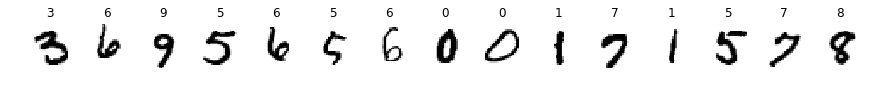

In [5]:
fig1, ax1 = plt.subplots(1,15, figsize=(15,10))
for i in range(15):
    ax1[i].imshow(X_test[i].reshape((28,28)), cmap="gray_r")
    ax1[i].axis('off')
    ax1[i].set_title(y_test[i])

Some digits are not easily recognized by human eyes... 

## Code - methods and classes <a class="anchor" id="methods"></a>

As I don't like to fill this kernel with same code used for different cases again and again, I will store it here. I hope, this makes it also easier for you to play with this kernel if you like to fork :-)

### Attack class

I have written a small class that performs the attack of logistic regression:

In [6]:
class Attack:

    def __init__(self, model):
        self.fooling_targets = None
        self.model = model
    
    def prepare(self, X_train, y_train, X_test, y_test):
        self.images = X_test
        self.true_targets = y_test
        self.num_samples = X_test.shape[0]
        self.train(X_train, y_train)
        print("Model training finished.")
        self.test(X_test, y_test)
        print("Model testing finished. Initial accuracy score: " + str(self.initial_score))
    
    def set_fooling_targets(self, fooling_targets):
        self.fooling_targets = fooling_targets
    
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.weights = self.model.coef_
        self.num_classes = self.weights.shape[0]

    def test(self, X_test, y_test):
        self.preds = self.model.predict(X_test)
        self.preds_proba = self.model.predict_proba(X_test)
        self.initial_score = accuracy_score(y_test, self.preds)
    
    def create_one_hot_targets(self, targets):
        self.one_hot_targets = np.zeros(self.preds_proba.shape)
        for n in range(targets.shape[0]):
            self.one_hot_targets[n, targets[n]] = 1
            
    def attack(self, attackmethod, epsilon):
        perturbed_images, highest_epsilon = self.perturb_images(epsilon, attackmethod)
        perturbed_preds = self.model.predict(perturbed_images)
        score = accuracy_score(self.true_targets, perturbed_preds)
        return perturbed_images, perturbed_preds, score, highest_epsilon
    
    def perturb_images(self, epsilon, gradient_method):
        perturbed = np.zeros(self.images.shape)
        max_perturbations = []
        for n in range(self.images.shape[0]):
            perturbation = self.get_perturbation(epsilon, gradient_method, self.one_hot_targets[n], self.preds_proba[n])
            perturbed[n] = self.images[n] + perturbation
            max_perturbations.append(np.max(perturbation))
        highest_epsilon = np.max(np.array(max_perturbations))
        return perturbed, highest_epsilon
    
    def get_perturbation(self, epsilon, gradient_method, target, pred_proba):
        gradient = gradient_method(target, pred_proba, self.weights)
        inf_norm = np.max(gradient)
        perturbation = epsilon/inf_norm * gradient
        return perturbation
    
    def attack_to_max_epsilon(self, attackmethod, max_epsilon):
        self.max_epsilon = max_epsilon
        self.scores = []
        self.epsilons = []
        self.perturbed_images_per_epsilon = []
        self.perturbed_outputs_per_epsilon = []
        for epsilon in range(0, self.max_epsilon):
            perturbed_images, perturbed_preds, score, highest_epsilon = self.attack(attackmethod, epsilon)
            self.epsilons.append(highest_epsilon)
            self.scores.append(score)
            self.perturbed_images_per_epsilon.append(perturbed_images)
            self.perturbed_outputs_per_epsilon.append(perturbed_preds)

### Attack methods 

In [7]:
def calc_output_weighted_weights(output, w):
    for c in range(len(output)):
        if c == 0:
            weighted_weights = output[c] * w[c]
        else:
            weighted_weights += output[c] * w[c]
    return weighted_weights

def targeted_gradient(foolingtarget, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(output)):
        if k == 0:
            gradient = foolingtarget[k] * (w[k]-ww)
        else:
            gradient += foolingtarget[k] * (w[k]-ww)
    return gradient

def non_targeted_gradient(target, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(target)):
        if k == 0:
            gradient = (1-target[k]) * (w[k]-ww)
        else:
            gradient += (1-target[k]) * (w[k]-ww)
    return gradient

def non_targeted_sign_gradient(target, output, w):
    gradient = non_targeted_gradient(target, output, w)
    return np.sign(gradient)

## Training the model <a class="anchor" id="training"></a>

First of all we need a model for multiclass logistic regression:

In [8]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', fit_intercept=False)

And we will pass it to our class and call prepare. This way we train our model on training data and we will obtain the initial accuracy score on test data. Later on we want to break down this score by perturbing the test data.

In [9]:
attack = Attack(model)
attack.prepare(X_train, y_train, X_test, y_test)

Model training finished.
Model testing finished. Initial accuracy score: 0.909345238095238


Ok, around 90 percent of test data was classified correctly and for us this is sufficient to play with. In multiclass logistic regression the probability that the model outputs $y_{n}$ of $N$ inputs $x_{n}$ matches their targets $t_{n}$ is given by:

$$ 
p(t|y(x,w)) = \prod_{n=1}^{N} \prod_{k=1}^{K} y_{n,k}^{t_{n,k}} 
$$

We assumed that inputs and class memberships are independent and identically distributed. The target $t_{n}$ of one input $x_{n}$ is a vector with K elements following one-hot-encoding (the true label class is 1, all others are 0). Maximizing the probability of matches above is also called the maximum likelihood approach. Each class in a multiclass logistic regression has its own weight vector and inputs are passed with weights through the softmax function to obtain the model output:

$$ 
y_{n,k} = \frac{\exp(w_{k}^{T}x_{n})} {\sum_{c=1}^{K}\exp(w_{c}^{T}x_{n})}
$$

Let's check if we have as much weight vectors as classes:

In [10]:
weights = attack.weights
weights.shape

(10, 784)

In [11]:
num_classes = len(np.unique(y_train))
num_classes

10

:-)

## Non-targeted Attack: Maximizing output-target discrepance <a class="anchor" id="nontargeted"></a>

In analogy to the maximum likelihood approach I define a discrepancy function as my objective. Usually the likelihood gives us the probability that our model output y matches the target t. Thus maximizing the likelihood yields us the best matches. Creating an attack one has to think the other way round: We want to maximize the probability that the outputs do not match the targets. Let's write down this descrepancy function by using the multinomial distribution again:

$$ D(t|y(w,x)) = \prod_{n=1}^{N} \prod_{k=1}^{K} y_{n,k}^{1-t_{n,k}} $$

Notice that in contrast to the likelihood function we now have 1-t instead of t. If our true target $t_{n,k}$ of class k for input $x_{n}$ is 1, but our model predicts $y_{n,k}=0$, then we have $0^{1-1}=1$ and vice versa $1^{1-0}=1$.  

To train a model we usually would maximize the likelihood with respect to the weight parameters whereas inputs are fixed. In our case we already have a trained model and fixed weights. But we can add tiny perturbations to our input images such that we maximize our discrepancy function. Let's do that and for making things simpler we use the log! :-)

$$\nabla_{x} \hat{D} = \nabla_{x} log D = \nabla_{x} \sum_{n=1}^{N} \sum_{k=1}^{K} (1-t_{k}) \log y_{k} $$

$$\hat{D} = \sum_{n=1}^{N} \sum_{k=1}^{K} (1-t_{n,k}) \log y_{n,k}$$

$$ \partial_{x} \hat{D} = \sum_{n=1}^{N} \sum_{k=1}^{K} \frac {\partial \hat{D}}{\partial y_{k}} \frac {\partial y_{k}}{\partial x} $$

The first part is easy:

$$ \frac {\partial \hat{D}}{\partial y_{k}}  = \frac {1-t_{k}} {y_{k}}$$

For the second part we should keep in mind the gradient of activations yields the class weight vector:

$$ a_{c} = \vec{w_{c}}^{T} \vec{x} = \vec{x}^{T} \vec{w_{c}} $$

$$ \nabla_{x} a_{c} = \vec{w_{c}} $$

$$ y_{k} = \frac{\exp(a_{k})} {\sum_{c=1}^{K}\exp(a_{c})}$$

Now this second part is a bit cumbersome (... hopefully I didn't make a mistake ...):

$$ \frac {\partial y_{k}}{\partial x} = \frac{\Sigma \cdot \partial_{x} \exp(a_{k}) - \exp(a_{k}) \partial_{x} \Sigma}{\Sigma^{2}} = \frac {\sum_{c=1}^{K} \exp(a_{c}) \cdot \vec{w}_{k} \exp(a_{k}) - \exp(a_{k}) \sum_{c=1}^{K} \vec{w}_{c} \exp(a_{c})} {\sum_{c=1}^{K}\exp(a_{c}) \cdot \sum_{c=1}^{K}\exp(a_{c})} $$

$$ \frac {\partial y_{k}}{\partial x} =  y_{k} \vec{w}_{k} - y_{k} \cdot \sum_{c=1}^{K} y_{c} \vec{w}_{c}  $$

Finally I end up with:

$$ \nabla_{x} \log D = \sum_{k=1}^{K} (1-t_{k}) \cdot  (\vec{w}_{k} - \sum_{c=1}^{K} y_{c} \vec{w}_{c}) $$

Let's try to understand this: For the true label the summand is 0 whereas all other classes contribute to the gradient with their class weight vector $\vec{w_{k}}$ reduced by an output "weighted" sum of all other class weights. What does that mean? ...

To maximize the discrepance for playing around we can use gradient ascent. Though we have to find a sufficient rate $\eta$. Given an input $x_{m}$ we will then add a perturbation with:

$$ x_{p, m} = x_{m} + \delta x_{m} = x_{m} + \eta \cdot \nabla_{x_{m,c}} \hat{D}_{m,c} $$

$$ x_{p, m} = x_{m} + \eta \sum_{k=1}^{K} (1-t_{m,k}) \cdot  (\vec{w}_{k} - \sum_{c=1}^{K} y_{m,c} \vec{w}_{c}) $$

Let's give it a try! :-)

### Adding tiny perturbations

First of all we need to calculate the perturbations for each image in the test set. To do this we have to transform our true targets to one-hot-targets and call attack :-). As I want to see, how much epsilon we need to create a good breakdown, I use the attack_to_max_epsilon method. 

In [12]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(non_targeted_gradient, 30)
non_targeted_scores = attack.scores

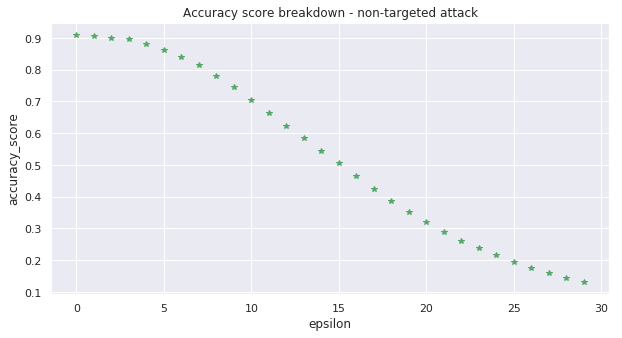

In [13]:
sns.set()
plt.figure(figsize=(10,5))
plt.plot(attack.epsilons, attack.scores, 'g*')
plt.ylabel('accuracy_score')
plt.xlabel('epsilon')
plt.title('Accuracy score breakdown - non-targeted attack');

Uii, the threshold is given by a max of 16 pixel that are allowed to be added as perturbation per pixel per image. Given this $\epsilon$ we would end up with a model that still predicts around 40 % correctly. If we would use max $\epsilon=30$ the model would fail with almoast 90 % digits in the test set :-) . Let's have a look at one example of successful fooling for a range of epsilons until max of $\epsilon = 16$.

In [14]:
eps = 16
attack.epsilons[eps]

16.0

We need the perturbed images as well as the fooling results of that epsilon:

In [15]:
example_images = attack.perturbed_images_per_epsilon[eps]
example_preds = attack.perturbed_outputs_per_epsilon[eps]

And I will store results in a pandas dataframe such that we can easily find successful foolings:

In [16]:
example_results = pd.DataFrame(data=attack.true_targets, columns=['y_true'])
example_results['y_fooled'] = example_preds
example_results['y_predicted'] = attack.preds
example_results['id'] = example_results.index.values
example_results.head()

,y_true,y_fooled,y_predicted,id
0,3,8,3,0
1,6,6,6,1
2,9,9,9,2
3,5,8,5,3
4,6,6,6,4


In [17]:
success_df = example_results[example_results.y_fooled != example_results.y_true]
success_df.head()

,y_true,y_fooled,y_predicted,id
0,3,8,3,0
3,5,8,5,3
5,5,9,0,5
6,6,2,6,6
14,8,5,8,14


Ok, we will choose one of these successful examples and plot its related perturbed image over a range of epsilons: 

In [18]:
example_id = success_df.id.values[0]
example_id

0

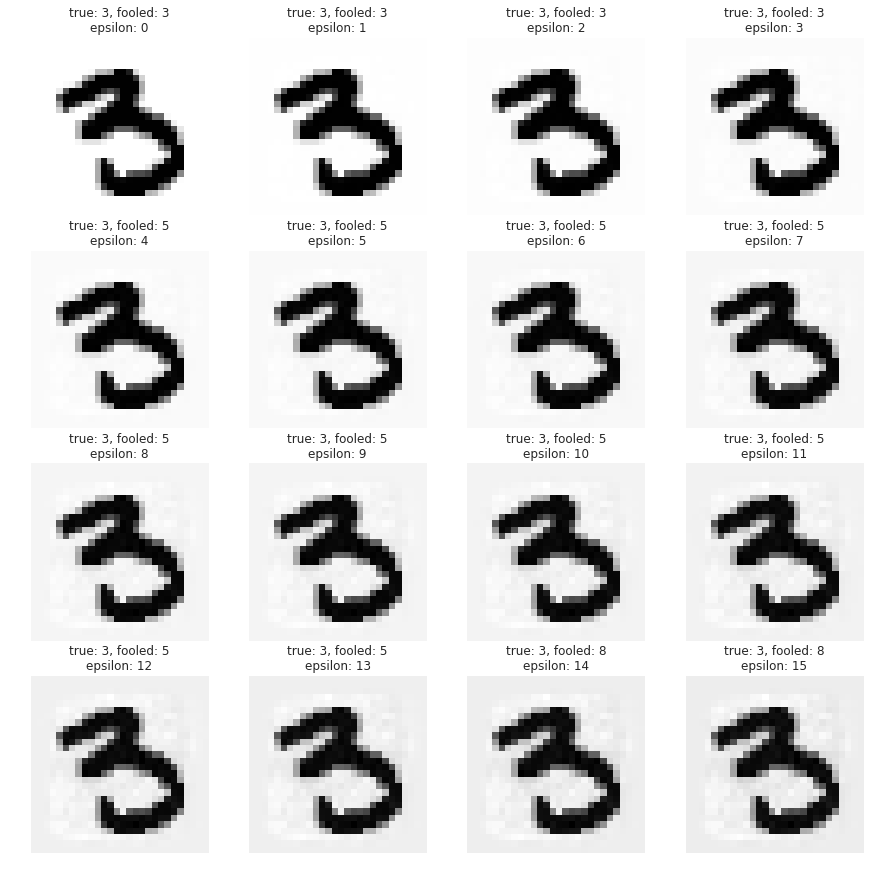

In [19]:
fig2, ax2 = plt.subplots(4,4, figsize=(15,15))
for i in range(4):
    for j in range(4):
        image = attack.perturbed_images_per_epsilon[i*4 + j][example_id]
        y_fooled = attack.perturbed_outputs_per_epsilon[i*4 + j][example_id]
        epsilon = attack.epsilons[i*4 +j]
        ax2[i,j].imshow(image.reshape((28,28)), cmap="gray_r")
        ax2[i,j].axis('off')
        ax2[i,j].set_title("true: " + str(y_test[example_id]) + ", fooled: " + str(y_fooled)  + "\n" 
                           + "epsilon: " + str(np.int(epsilon)))

Yeah! :-) We can still see the true target and not the fooling target. That's amazing. But we can also see, that the background has increased intensitiy. Let's visualize the difference between the original true label and the adversarial image for $\epsilon = 16$: 

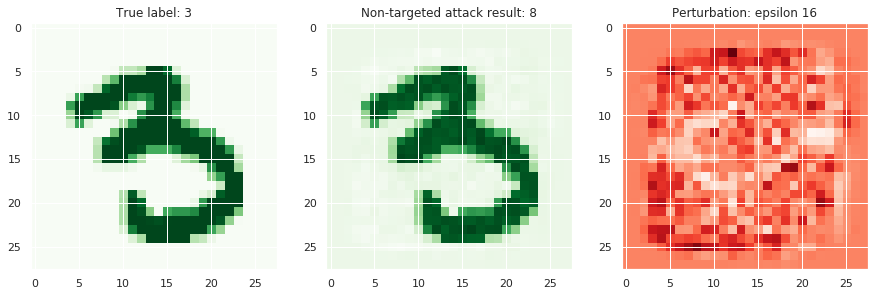

In [20]:
fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15,5))
axB.imshow(example_images[example_id].reshape((28,28)), cmap='Greens')
axB.set_title("Non-targeted attack result: " + str(example_preds[example_id]))
axA.imshow(X_test[example_id].reshape((28,28)), cmap='Greens')
axA.set_title("True label: " + str(y_test[example_id]))
axC.imshow((X_test[example_id]-example_images[example_id]).reshape((28,28)), cmap='Reds')
axC.set_title("Perturbation: epsilon 16");

### The gradient travel guide - natural fooling targets

I'm happy that it was possible to fool our model but it's still diffuse and unclear where the one-step-gradient guides us through (remember we do not iterate with gradient ascent, we just take one step and size is given by strength of gradient times eta). I assume that some numbers are closer to each other in weight space than to others. As the model training draws decision boundaries dependent on the quality of the input data and flexibility of model architecture, there will be regions where a 3 is not predicted as 3 but as 8. Those regions where the model makes an incorrect prediction. And I think, that there are preffered numbers to be wrong predictions given a digit input image. Perhaps the fooling gradients drives us to those "natural" fooling target numbers? 

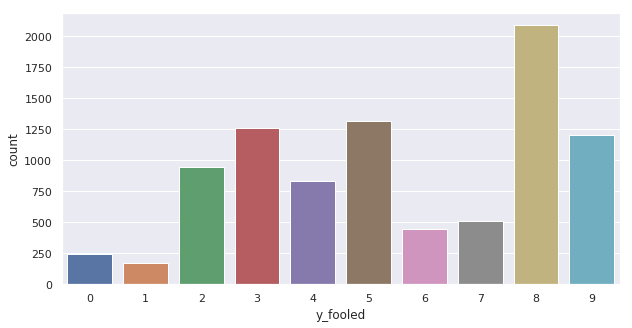

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(x='y_fooled', data=example_results[example_results.y_true != example_results.y_fooled])

Ok, we see that 8 was selected most often as fooling target. But 9, 3, 5 and 2 have high counts as well in contrast to 0, 1, 6 and 7. If our assumption is true that the gradient drives us to targets where the model tends to fail in prediction we should see a similar pattern of counts for wrong predictions:

In [22]:
wrong_predictions = example_results[example_results.y_true != example_results.y_predicted]
wrong_predictions.shape

(1523, 4)

In [23]:
X_test.shape

(16800, 784)

Ok, so out of 16800 samples, the model failed to predict around 1600. That's why our intital accuracy score is close to 90 % (means 10 % failing). Now, which digit was selected as wrong prediction result most often?

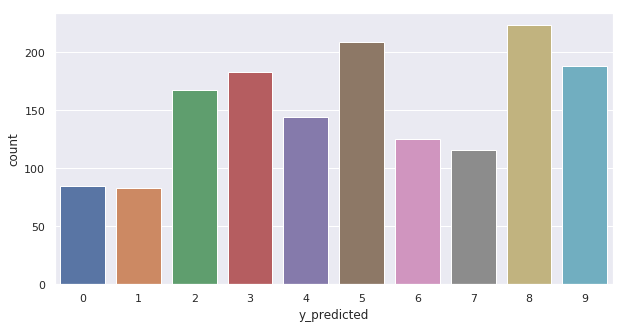

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(x='y_predicted', data=wrong_predictions)

Yes, that's the same pattern as for the fooling targets. As this is caused by the difficulty of our model to draw good decision boundaries we should see this pattern as well for the true labels of those digits that were wrong predicted:

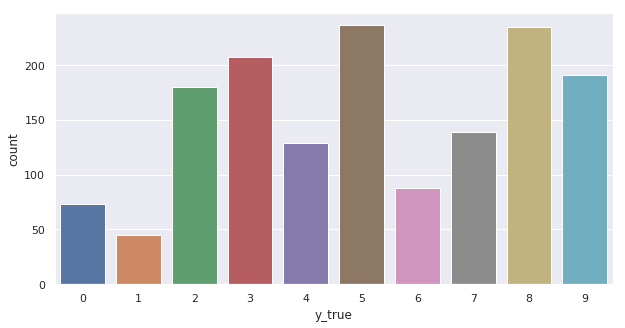

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(x='y_true', data=wrong_predictions)

 Now I want to see it in more detail: Which are the natural fooling targets (for successful foolings) for each digit?

In [26]:
attacktargets = example_results.loc[example_results.y_true != example_results.y_fooled].groupby(
    'y_true').y_fooled.value_counts()
counts = example_results.loc[example_results.y_true != example_results.y_fooled].groupby(
    'y_true').y_fooled.count()
attacktargets = attacktargets/counts * 100
attacktargets = attacktargets.unstack()
attacktargets = attacktargets.fillna(0.0) 
attacktargets = attacktargets.apply(np.round).astype(np.int)

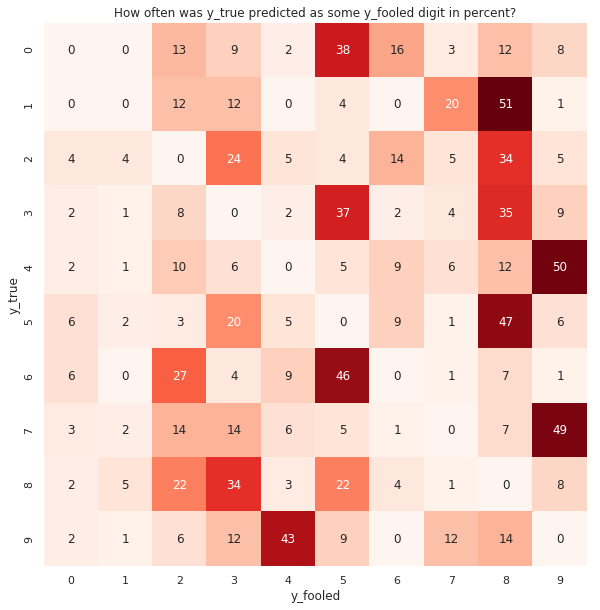

In [27]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(attacktargets, annot=True, ax=ax, cbar=False, square=True, cmap="Reds", fmt="g");
ax.set_title("How often was y_true predicted as some y_fooled digit in percent?");

We found out that each digit has its natural fooling target. For example 3 was likely predicted as 5 or 8 which makes sense as all three have "two bubbles" on top of each other as a sketch shape. You can see that 8 was a good fooling choice for several digits... interestingly for 1 as well. In addition we find that for some images both holds: 4 and 9 for example are possible in both ways.

## Targeted-Attack <a class="anchor" id="targeted"></a>

We have seen that fooling the multiclass logistic regression model was easy with gradient ascent and the only cumbersome part was to calculate the gradient with respect to the inputs of our discrepance function. Instead of forcing the function to yield the maximum discrepance we could have also construct it such that outputs have to match a specific false target. To emphasize the difference to the true target $t_{n,k}$ let's call it $f_{n,k}$ for "fooling" target.

$$ D(t|y(w,x)) = \prod_{n=1}^{N} \prod_{k=1}^{K} y_{n,k}^{f_{n,k}} $$

Luckily we do not have to calculate everything again, the only thing that changes is:

$$ \frac {\partial D}{\partial y_{k}}  = \frac {f_{k}} {y_{k}} $$

Consequently we have:

$$ \nabla_{x} \log D = \sum_{k=1}^{K} f_{k} \cdot  (\vec{w}_{k} - \sum_{c=1}^{K} y_{c} \vec{w}_{c}) $$

$$ x_{p, m} = x_{m} + \eta \sum_{k=1}^{K} f_{k} \cdot  (\vec{w}_{k} - \sum_{c=1}^{K} y_{m,c} \vec{w}_{c}) $$

### One example image

To play around, let's select one input of $X_{test}$ and try to make targeted attacks for each class $f_{k}$ except for the true label target $t_{k}$. 

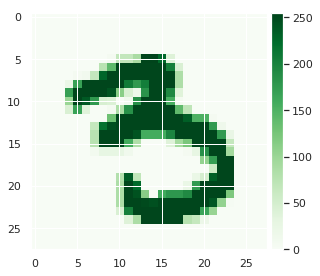

In [28]:
example = X_test[0]
imshow(example.reshape((28,28)), cmap='Greens');

In [29]:
print("true label target: " + str(y_test[0]))

true label target: 3


### Generating the fooling/attack classes and targets

First of all, we need some fooling targets. For our example digit all others are possible:

In [30]:
fooling_classes = []
for k in range(num_classes):
    if k != y_test[0]:
        fooling_classes.append(k)
fooling_classes

[0, 1, 2, 4, 5, 6, 7, 8, 9]

In [31]:
foolingtargets = np.zeros((len(fooling_classes), num_classes))
for n in range(len(fooling_classes)):
    foolingtargets[n,fooling_classes[n]] = 1
foolingtargets

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### Attacking the model

I will force the attack to success by allowing an epsilon high enough to yield all targets. This way we can still find out, if we can see the true label or the fooling target.

In [32]:
eps=100
targeted_perturbed_images = []
targeted_perturbed_predictions = []
for fooling_target in foolingtargets:   
    targeted_perturbation = attack.get_perturbation(eps, targeted_gradient, fooling_target, attack.preds_proba[0])
    targeted_perturbed_image = X_test[0] + targeted_perturbation
    targeted_perturbed_prediction = attack.model.predict(targeted_perturbed_image.reshape(1, -1))
    targeted_perturbed_images.append(targeted_perturbed_image)
    targeted_perturbed_predictions.append(targeted_perturbed_prediction)

In [33]:
targeted_perturbed_predictions

[array([0]),
 array([1]),
 array([2]),
 array([4]),
 array([5]),
 array([8]),
 array([7]),
 array([8]),
 array([9])]

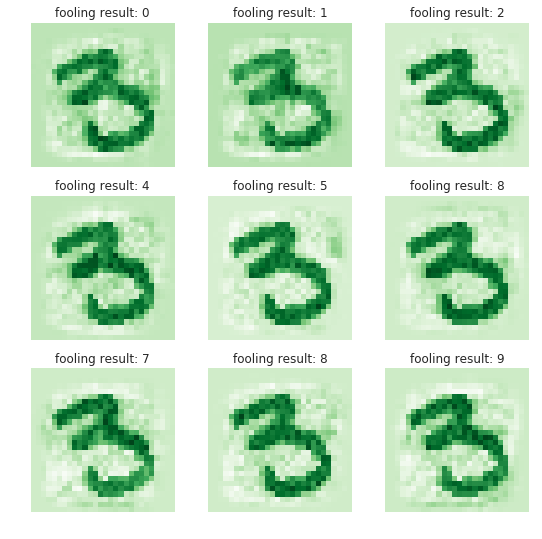

In [34]:
fig3, ax3 = plt.subplots(3,3, figsize=(9,9))
for i in range(3):
    for j in range(3):
        ax3[i,j].imshow(targeted_perturbed_images[i*3+j].reshape((28,28)), cmap="Greens")
        ax3[i,j].axis('off')
        ax3[i,j].set_title("fooling result: " + str(targeted_perturbed_predictions[i*3+j][0]))

Even though we can see high background noise the true label is not destroyed. I can still see the true label with my eyes whereas the model predicts the desired fooling target (0 to 9, except true label). :-) That's cool.

## Natural vs. non-natural targeted attack

Now, I like to see what happens with the accuracy score if we fool the model for each image in the test set. 
By analyzing non-targeted attacks we found that some digits are more used as "fooling" target than others and that each digit has its fooling digit counterpart. I assume that fooling takes place in regions where the model fails to draw good decision boundaries. Using targeted attack we should see that we can breakdown the accuracy score easier with natural fooling targets than with the other digits. Let's try this! :-)

### Prepare natural and non-natural fooling targets

The gradient travel guide showed us the occurences of fooling target digits for each true digit. The highest count stands for the natural fooling target whereas the lowest corresponds to the non-natural fooling target. Given the heatmap we could create the targets by argmin and argmax per row (y_true) as follows:

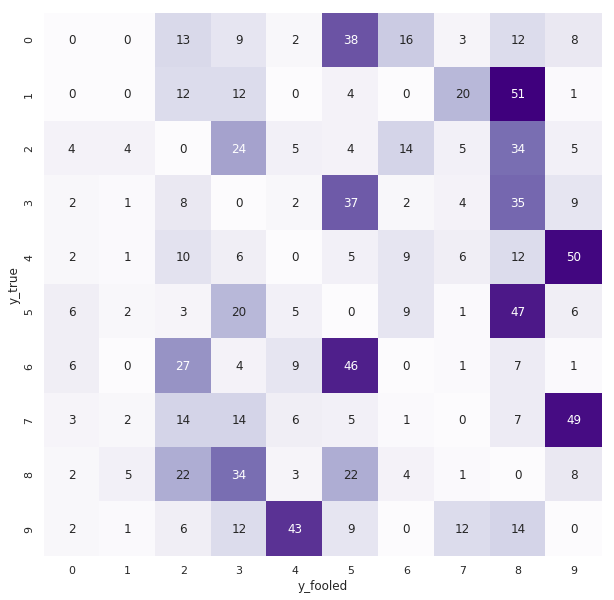

In [35]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(attacktargets, annot=True, ax=ax, cbar=False, cmap="Purples", fmt="g");

In [36]:
natural_targets_dict = {}
non_natural_targets_dict = {}
for ix, series in attacktargets.iterrows():
    natural_targets_dict[ix] = series.argmax()
    non_natural_targets_dict[ix] = series.drop(ix).argmin()

In [37]:
natural_targets_dict

{0: 5, 1: 8, 2: 8, 3: 5, 4: 9, 5: 8, 6: 5, 7: 9, 8: 3, 9: 4}

In [38]:
natural_foolingtargets = np.zeros((y_test.shape[0]))
non_natural_foolingtargets = np.zeros((y_test.shape[0]))

for n in range(len(natural_foolingtargets)):
    target = y_test[n]
    natural_foolingtargets[n] = natural_targets_dict[target]
    non_natural_foolingtargets[n] = non_natural_targets_dict[target]

In [39]:
attack.create_one_hot_targets(natural_foolingtargets.astype(np.int))
attack.attack_to_max_epsilon(targeted_gradient, 30)
natural_scores = attack.scores
attack.create_one_hot_targets(non_natural_foolingtargets.astype(np.int))
attack.attack_to_max_epsilon(targeted_gradient, 30)
non_natural_scores = attack.scores

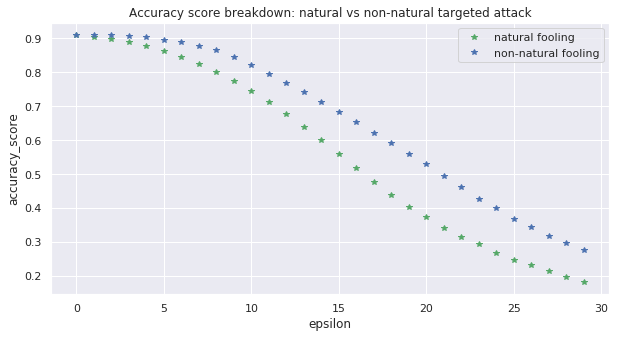

In [40]:
plt.figure(figsize=(10,5))
nf, = plt.plot(attack.epsilons, natural_scores, 'g*', label='natural fooling')
nnf, = plt.plot(attack.epsilons, non_natural_scores, 'b*', label='non-natural fooling')
plt.legend(handles=[nf, nnf])
plt.ylabel('accuracy_score')
plt.xlabel('epsilon')
plt.title('Accuracy score breakdown: natural vs non-natural targeted attack');

Ahhh! :-) We can clearly see that it was easier to fool the model with natural fooling targets.

## Comparison to Fast Gradient Method <a class="anchor" id="fastgradient"></a>


So far we have used gradient ascent to maximize the probability of no-matches (non-targeted & targeted) and we derived the gradient with respect to inputs for objectives that are only slightly changed in comparison to the model defining likelihood function. This way we are very close to the Fast Gradient Method given in the cleverhans library:


* Maximizing probability of no-matches:

$$ x_{p, m} = x_{m} + \delta x_{m} = x_{m} + \eta \cdot \nabla_{x_{m}} D(f_{m}|y_{m}(x_{m},w)) $$

* Fast Gradient Method:

$$ x_{p,m} = x_{m} + \delta x_{m} = x_{m} + \eta \cdot sign (\nabla_{x_{m}} J(w,x,y)) $$

Whereas $J(w,x,y)$ stands for the cost function used to train the model.  In many cases this is $E=- \log (L(t|y(x,w))$, the negative log likelihood function. One might think that this should also be the case for this example and that we could have also simply maximize the cost funtion. As this would be the same as to minimize the log-likelihood, one might think:

** ... instead of defining a discrepance function one could have also just minimize the likelihood function to yield the lowest probability of matches... **

Ohoh! Is this true? Sounds so nice, but... 

### Maximizing discrepance = minimizing likelihood?

Normally we use the likelihood to maximize the probability and we want to count those outputs $y_{n,c}$ related to target-values of $t_{n,c}=1$. Look at one example image $m$ that belongs to class 2 of 3, then for this one we would have:

$$ l = y_{1}^{0} * y_{2}^{1} * y_{3}^{0} = y_{2} $$

Hence this image contribute to the overall product over $n$ by a factor of $y_{2}$. Consequently each image $n$ would give us a y-factor of its true class whereas all the others only give us a factor of 1 such that it does not disturb our nice probability. If we would now use the same likelihood to represent the probability of no-matches we encounter a problem: To minimize the likelihood the only thing that can be done now is to set $y_{2}=0$ for image m. We would do this for all outputs that enter the likelihood by themselves. But what is with all the others? What to do with $y_{1}$ and $y_{3}$ for image m? Looking for a minimum of $y_{2}$ we could select anything for $y_{1}$ and $y_{3}$ as they just stay 1. That's ill-defined in contrast to our discrepance probability. There the situation for image m would look like this:

$$ l = y_{1}^{1} * y_{2}^{0} * y_{3}^{1} = y_{1} * y_{3} $$

And also our targeted-attack looks well for image m, if we define class 1 as our fooling class:

$$ l = y_{1}^{1} * y_{2}^{0} * y_{3}^{0} = y_{1} $$

We have made sure that only those output-values enter the likelihood that are not related to the true target and we made sure that they carry their values and not just a value of 1. 

## Comparison to "discrepance" Gradient Sign Method

Some small experiment: Let's only take the sign of the gradient of our attack. I think we will not be as goog as we could be with the full gradient:

In [41]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(non_targeted_sign_gradient, 30)

Text(0.5,1,'Accuracy score breakdown')

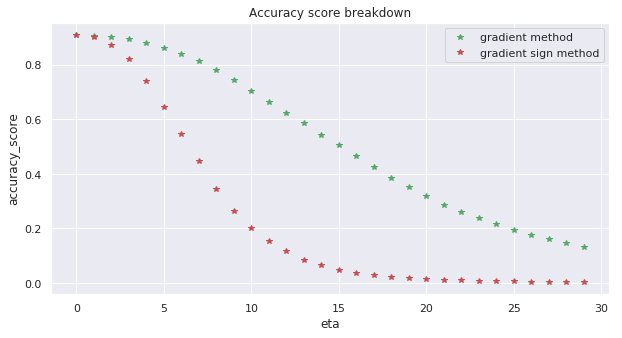

In [42]:
plt.figure(figsize=(10,5))
gm, = plt.plot(attack.epsilons, non_targeted_scores, 'g*', label='gradient method')
gsm, = plt.plot(attack.epsilons, attack.scores, 'r*', label='gradient sign method')
plt.ylabel('accuracy_score')
plt.xlabel('eta')
plt.legend(handles=[gm, gsm])
plt.title('Accuracy score breakdown')

Uiih!! :-o That's a surprise. 

## One step further: The Jacobian matrix <a class="anchor" id="jacobian"></a>

What if we would use the likelihood instead of the discrepance function to yield the perturbations? If you look at the equations, you can find a clear similarity:

$$ D(t|y(w,x)) = \prod_{n=1}^{N} \prod_{k=1}^{K} y_{n,k}^{f_{n,k}} $$

$$ \nabla_{x} \log D = \sum_{k=1}^{K} f_{k} \cdot  (\vec{w}_{k} - \sum_{c=1}^{K} y_{c} \vec{w}_{c}) $$

$$ L(t|y(x,w)) = \prod_{n=1}^{N} \prod_{k=1}^{K} y_{n,k}^{t_{n,k}} $$

$$ \nabla_{x} \log L = \sum_{k=1}^{K} t_{k} \cdot  (\vec{w}_{k} - \sum_{c=1}^{K} y_{c} \vec{w}_{c}) $$

The difference is the use of either the true label $t_{n,k}$ or the fooling target $f_{n,k}$. What remains the same is the gradient of output $y_{k}$ of class $k$ with respect to all features $x$ (pixels) of one single image.

$$ \frac {\partial y_{k}}{\partial x} =  y_{k} \vec{w}_{k} - y_{k} \cdot \sum_{c=1}^{K} y_{c} \vec{w}_{c}  $$

Taking the derivative of the outputs for each class $\partial y_{k}$ with respect to the input features $\partial x_{d}$ (with d in range for 1 to 64 pixel) we have arrived at the **Jacobian matrix**: 

$$
\begin{bmatrix}
\frac{\partial y_{1}}{\partial x_{1}}	& \frac{\partial y_{1}}{\partial x_{2}}	& \dots	 & \frac{\partial y_{1}}{\partial x_{64}}     \\
\frac{\partial y_{2}}{\partial x_{1}}	& \frac{\partial y_{2}}{\partial x_{2}} 	& \dots  & \frac{\partial y_{2}}{\partial x_{64}} 	  \\
\vdots	& \vdots 	& \ddots & \vdots \\
\frac{\partial y_{10}}{\partial x_{1}} 	& \dots & \dots	 & \frac{\partial y_{10}}{\partial x_{64}}
\end{bmatrix}
$$ 

Now, in each row we have one vector of $\frac {\partial y_{k}}{\partial x}$. But that's not all! Have a closer look at the equations of $ \nabla_{x} \log L $ and $ \nabla_{x} \log D$. What are $t_{n,k}$ and $f_{n,k}$ doing here? ...

They are working like a mask. :-)

...

Not every class contributes to the gradient! As we use one-hot-encoding, only the class with the $1$ yields a summand which is not 0. Looking at the Jacobian this means that all rows are 0 except for the class that is represented by 1 in the encoding of $t_{n,k}$ or $f_{n,k}$. Let's call this specific class $\hat{k}$, then we have:

$$ \nabla_{x} \log D =  \vec{w}_{\hat{k}} - \sum_{c=1}^{K} y_{c} \vec{w}_{c} $$

$$ \nabla_{x} \log L =  \vec{w}_{\hat{k}} - \sum_{c=1}^{K} y_{c} \vec{w}_{c} $$

But take in mind: $\hat{k}$ is different for the both equations: one is the fooling class and the other the true label class and of course they are not the same! :-)

### Why could this be important?



This looks like playing with equations but we gained an insight: We have found that we could express the perturbation by a masking of the Jacobian matrix. The letter tells us more generally how the outputs of all classes change with input perturbations. This is already a hint that we could built attacks and defenses on approaches based on the Jacobian. Besides the Fast Gradient Attack you can find a Jacobian-based approach as well. Have fun to explore! :-)

# Conclusion <a class="anchor" id="conclusion"></a>

My public journey has come to end. I have still ideas to play with but this kernel is already too long for an introduction. Feel free to fork, try different epsilons, only use the sign method, use dimensionality reductions as influence property.... there is so much to do :-) . For me it was the first time to fool a machine learning model and I learnt:

1. One could easily fool a model if one has access to the learned weights and by defining own objectives that maximize the discrepance between targets and model outputs. (One could also fool without knowing weights or model architecture, but that's another topic...)
2. Fooling takes place in regions where the model fails to draw good decision boundaries which of course depends on the model architecture/flexibility but on the input data quality and preprocessing as well.
3. Due to the fact that some inputs are closer to each other in meanings of decision boundaries, there exist natural and non-natural fooling targets.


Have fun and good luck, so far :-)